In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler, StandardScaler , RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных с Kaggle  - если хочется также получить данные, то нужно раскоментить строки и положить json со своим токеном в директорию. Или же просто использовать загруженные локально csv

In [2]:
#! pip install kaggle

In [3]:
#! mkdir ~/.kaggle

In [4]:
#! cp kaggle.json ~/.kaggle/

In [5]:
#! chmod 600 ~/.kaggle/kaggle.json

In [6]:
#kaggle competitions download -c study-competition-1-dl-2024

In [7]:
#!unzip study-competition-1-dl-2024.zip

# Шаг 1. Поизучать данные, посмотреть, какие данные можно выбросить.

# Посмотрим на тренировочный датасет

In [8]:
train = pd.read_csv('train.csv' , sep = ';')
train

id          f1    f2    f3    f4    f5   f6      f7   f8    f9  ...  \
0      0.0  19.08.2014  37.0  19.0   5.0  16.0  1.0  1984.0  1.0   9.0  ...   
1      1.0  22.01.2014  53.0  30.0  10.0  12.0  1.0  1983.0  2.0   8.0  ...   
2      2.0  30.07.2012  38.0  17.0  11.0   NaN  NaN     NaN  NaN   NaN  ...   
3      3.0  21.08.2012  75.0   NaN   2.0   NaN  NaN     NaN  NaN   NaN  ...   
4      4.0  31.12.2013  35.0  19.0   6.0  12.0  1.0  1971.0  1.0  10.0  ...   
...    ...         ...   ...   ...   ...   ...  ...     ...  ...   ...  ...   
24371  NaN         NaN   NaN   NaN   NaN   NaN  NaN     NaN  NaN   NaN  ...   
24372  NaN         NaN   NaN   NaN   NaN   NaN  NaN     NaN  NaN   NaN  ...   
24373  NaN         NaN   NaN   NaN   NaN   NaN  NaN     NaN  NaN   NaN  ...   
24374  NaN         NaN   NaN   NaN   NaN   NaN  NaN     NaN  NaN   NaN  ...   
24375  NaN         NaN   NaN   NaN   NaN   NaN  NaN     NaN  NaN   NaN  ...   

        f283   f284  f285  f286   f287  f288  f289   f290  f291      target  
0        6.0    2.0   0.0   4.0    8.0   0.0   2.0   21.0   5.0   4900000.0  
1      290.0  120.0  24.0  92.0  165.0   1.0  75.0  167.0  13.0  13500000.0  
2       15.0    4.0   0.0  13.0   28.0   1.0   2.0   82.0   9.0   6100000.0  
3        4.0    2.0   0.0   3.0   15.0   1.0   0.0   24.0   4.0   5662500.0  
4       18.0    1.0   0.0   5.0   14.0   0.0   4.0   44.0   5.0   4999000.0  
...      ...    ...   ...   ...    ...   ...   ...    ...   ...         ...  
24371    NaN    NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN         NaN  
24372    NaN    NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN         NaN  
24373    NaN    NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN         NaN  
24374    NaN    NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN         NaN  
24375    NaN    NaN   NaN   NaN    NaN   NaN   NaN    NaN   NaN         NaN  

[24376 rows x 293 columns]

# Пример сабмишена

In [9]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

id  prediction
0     19999           0
1     20000           0
2     20001           0
3     20002           0
4     20003           0
...     ...         ...
4373  24372           0
4374  24373           0
4375  24374           0
4376  24375           0
4377  24376           0

[4378 rows x 2 columns]

# Тестовый набор

In [10]:
test = pd.read_csv('test.csv' , sep = ';')
test

id          f1  f2    f3    f4    f5   f6      f7   f8   f9  ...  \
0     19999  19.06.2014  41  20.0   9.0  14.0  1.0  1984.0  1.0  8.0  ...   
1     20000  25.02.2014  58  43.0   2.0   9.0  1.0  1971.0  3.0  6.0  ...   
2     20001  29.10.2014  35  14.0   4.0  23.0  1.0  2005.0  1.0  9.0  ...   
3     20002  27.11.2013  33  19.0   3.0   9.0  1.0  1971.0  1.0  6.0  ...   
4     20003  24.04.2013  53  30.0  11.0   NaN  NaN     NaN  NaN  NaN  ...   
...     ...         ...  ..   ...   ...   ...  ...     ...  ...  ...  ...   
4373  24372  02.04.2015  73   NaN  11.0  25.0  4.0     NaN  2.0  1.0  ...   
4374  24373  02.12.2014  44  17.0   5.0  14.0  1.0  2016.0  1.0  8.0  ...   
4375  24374  10.04.2012  37  19.0  12.0   NaN  NaN     NaN  NaN  NaN  ...   
4376  24375  27.06.2014  45  33.0   3.0   5.0  1.0  1964.0  2.0  5.0  ...   
4377  24376  01.04.2013  32   NaN   6.0   NaN  NaN     NaN  NaN  NaN  ...   

      f282 f283 f284  f285  f286  f287  f288  f289  f290  f291  
0       33    7    4     0    10    15     0     0    40     3  
1       20    5    3     0     7    25     0    10    56     7  
2       28    9    3     0    11    23     0     5    77    17  
3       19   13    8     1     8    13     0     2    46     0  
4       45   15    4     0    13    28     1     0    72     5  
...    ...  ...  ...   ...   ...   ...   ...   ...   ...   ...  
4373    55   32   11     1     8    27     2     5    70     4  
4374     6    2    2     0     1    12     1     0     7     0  
4375    18    3    1     0     7    12     0     7    32    10  
4376    22   15   11     1     7    17     0     2    46     0  
4377     4    2    2     0     2     9     0     0     7     3  

[4378 rows x 292 columns]

# Немного кривая история: тест и трейн кусок одного датасета, но данные трейна передаются почему-то криво и тестовый кусок лежит в трейне и просто заполнен нанами, поэтому отрежу нужную часть

In [11]:
train = train.head(19999)
train

id          f1    f2    f3    f4    f5   f6      f7   f8    f9  \
0          0.0  19.08.2014  37.0  19.0   5.0  16.0  1.0  1984.0  1.0   9.0   
1          1.0  22.01.2014  53.0  30.0  10.0  12.0  1.0  1983.0  2.0   8.0   
2          2.0  30.07.2012  38.0  17.0  11.0   NaN  NaN     NaN  NaN   NaN   
3          3.0  21.08.2012  75.0   NaN   2.0   NaN  NaN     NaN  NaN   NaN   
4          4.0  31.12.2013  35.0  19.0   6.0  12.0  1.0  1971.0  1.0  10.0   
...        ...         ...   ...   ...   ...   ...  ...     ...  ...   ...   
19994  19994.0  28.03.2012  45.0  25.0   3.0   NaN  NaN     NaN  NaN   NaN   
19995  19995.0  01.08.2014  48.0  30.0   3.0   5.0  1.0  1967.0  2.0   7.0   
19996  19996.0  21.12.2011  52.0  30.0  11.0   NaN  NaN     NaN  NaN   NaN   
19997  19997.0  02.06.2015  27.0  14.0   3.0   5.0  1.0  1966.0  1.0   5.0   
19998  19998.0  19.06.2014  41.0  20.0   9.0  14.0  1.0  1984.0  1.0   8.0   

       ...   f283   f284  f285  f286   f287  f288  f289   f290  f291  \
0      ...    6.0    2.0   0.0   4.0    8.0   0.0   2.0   21.0   5.0   
1      ...  290.0  120.0  24.0  92.0  165.0   1.0  75.0  167.0  13.0   
2      ...   15.0    4.0   0.0  13.0   28.0   1.0   2.0   82.0   9.0   
3      ...    4.0    2.0   0.0   3.0   15.0   1.0   0.0   24.0   4.0   
4      ...   18.0    1.0   0.0   5.0   14.0   0.0   4.0   44.0   5.0   
...    ...    ...    ...   ...   ...    ...   ...   ...    ...   ...   
19994  ...    7.0    2.0   0.0   6.0   23.0   0.0   7.0   62.0  13.0   
19995  ...    5.0    2.0   0.0   6.0   12.0   0.0   2.0   44.0   5.0   
19996  ...    3.0    1.0   0.0   5.0   12.0   1.0   0.0   27.0   3.0   
19997  ...   32.0   12.0   3.0  10.0   25.0   1.0   8.0   83.0   2.0   
19998  ...    7.0    4.0   0.0  10.0   15.0   0.0   0.0   40.0   3.0   

           target  
0       4900000.0  
1      13500000.0  
2       6100000.0  
3       5662500.0  
4       4999000.0  
...           ...  
19994   6100000.0  
19995   1000000.0  
19996   2000000.0  
19997   1500000.0  
19998   1000000.0  

[19999 rows x 293 columns]

# Датасет достаточно большой, поэтому установлю опции для работы со строками и столбцами

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Посмотрим на количество пропущенных значений в столбцах

In [13]:
train.isna().sum()

id           0
f1           0
f2           0
f3        4133
f4         102
f5        6223
f6        6223
f7        8889
f8        6223
f9        6223
f10       8809
f11          0
f12          0
f13          0
f14          0
f15          0
f16          0
f17          0
f18       4340
f19          0
f20          0
f21       4338
f22          0
f23          0
f24       9423
f25          0
f26          0
f27          0
f28          0
f29          0
f30          0
f31          0
f32          0
f33          0
f34          0
f35          0
f36          0
f37          0
f38          0
f39          0
f40          0
f41          0
f42          0
f43          0
f44          0
f45          0
f46          0
f47          0
f48          0
f49          0
f50          0
f51          0
f52          0
f53          0
f54          0
f55          0
f56          0
f57          0
f58          0
f59          0
f60          0
f61          0
f62          0
f63          0
f64          0
f65          0
f66       

# Если в столбце больше 10% пропущенных значений, то дропну их

In [14]:
columns_to_drop = train.columns[train.isnull().sum() >= 2799].tolist()
columns_to_drop

['f3',
 'f5',
 'f6',
 'f7',
 'f8',
 'f9',
 'f10',
 'f18',
 'f21',
 'f24',
 'f68',
 'f69',
 'f70',
 'f71',
 'f72',
 'f73',
 'f74',
 'f76',
 'f77',
 'f78',
 'f79',
 'f80',
 'f81',
 'f82',
 'f83',
 'f84',
 'f161',
 'f162',
 'f163',
 'f184',
 'f185',
 'f186',
 'f207',
 'f208',
 'f209']

In [15]:
len(columns_to_drop)

35

# Дропну колонки с большим количеством пропущенных и id - они не несут смысловой нагрузки, а, наоборот, могут снизить качество работы модели. Единственное, потом нужно будет приклеить айдишники при сборке сабмишена, но это не так сложно

In [16]:
train_dropped = train.drop(columns=columns_to_drop)
train_dropped.drop(columns = 'id', inplace = True)

In [17]:
train_dropped.isna().sum()

f1           0
f2           0
f4         102
f11          0
f12          0
f13          0
f14          0
f15          0
f16          0
f17          0
f19          0
f20          0
f22          0
f23          0
f25          0
f26          0
f27          0
f28          0
f29          0
f30          0
f31          0
f32          0
f33          0
f34          0
f35          0
f36          0
f37          0
f38          0
f39          0
f40          0
f41          0
f42          0
f43          0
f44          0
f45          0
f46          0
f47          0
f48          0
f49          0
f50          0
f51          0
f52          0
f53          0
f54          0
f55          0
f56          0
f57          0
f58          0
f59          0
f60          0
f61          0
f62          0
f63          0
f64          0
f65          0
f66          0
f67          0
f75          0
f85          0
f86          0
f87          0
f88         20
f89         20
f90          0
f91          0
f92          0
f93       

# Также проверю на дубликаты

In [18]:
train.duplicated().sum()

0

In [19]:
def histmaker_for_numeric_df(df, bins=20, figsize=(15, 5), palette='deep'):
    numeric_df = df.select_dtypes(include=np.number)

    sns.set(style='darkgrid', palette=palette)

    num_plots = len(numeric_df.columns)  # количество графиков
    num_rows = (num_plots - 1) // 3 + 1  # количество строк
    num_cols = min(num_plots, 3)         # количество столбцов

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], figsize[1] * num_rows))
    plt.suptitle('Гистограммы каждой фичи', fontsize=15)

    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < num_plots:
            ax.hist(numeric_df.iloc[:, i], bins=bins, edgecolor='black', alpha=0.7)
            ax.set_title(numeric_df.columns[i], weight='bold')
            if i % 3 == 0:
                ax.set_ylabel('Count')
    for ax in axes[num_plots:]:
        ax.remove()

# Предобработку разделю на 2 части: работа с числовыми фичами и категориальными. На первые довольно удобно посмотреть с помощью гистограммы - под прицелом фичи с ярко выраженным одним столбцом, что косвенно намекает на ненадобность этой фичи в модели. Также хорошей практикой является фичаинженеринг, но поскольку данные обезличенные, этот метод я отметаю - бессмысленно создавать новые чиселки из старых чиселок

In [95]:
#histmaker_for_numeric_df(train) Работает оч долго - много столбцов, но работает

# А вот с категориальными фичами простор для работы куда больше: разбираться будем подробнее с каждым типом

In [21]:
object_columns = train_dropped.select_dtypes(include=['object'])
object_columns

f1            f11                   f12  f29  f33  f34 f35  \
0      19.08.2014     Investment    Birjulevo Zapadnoe   no  yes  yes  no   
1      22.01.2014     Investment              Tverskoe  yes   no   no  no   
2      30.07.2012     Investment       Beskudnikovskoe   no   no   no  no   
3      21.08.2012  OwnerOccupier   Poselenie Sosenskoe   no   no   no  no   
4      31.12.2013     Investment  Ochakovo-Matveevskoe   no  yes   no  no   
...           ...            ...                   ...  ...  ...  ...  ..   
19994  28.03.2012     Investment             Kuz'minki   no   no   no  no   
19995  01.08.2014     Investment            Gol'janovo   no   no   no  no   
19996  21.12.2011     Investment       Severnoe Butovo   no   no   no  no   
19997  02.06.2015     Investment  Ochakovo-Matveevskoe   no  yes   no  no   
19998  19.06.2014     Investment           Dmitrovskoe   no  yes   no  no   

       f36  f37  f38  f39  f40                f75 f107 f115 f119          f153  
0      yes   no   no   no   no  951420565FDKEFFLd   no   no   no  satisfactory  
1      yes  yes   no   no  yes  951436827FDKEFFLd   no   no   no          poor  
2       no   no   no   no   no  951425415FDKEFFLd   no   no   no          poor  
3       no   no  yes   no   no  951423556FDKEFFLd   no   no   no       no data  
4       no   no   no   no   no  951420870FDKEFFLd   no   no   no  satisfactory  
...    ...  ...  ...  ...  ...                ...  ...  ...  ...           ...  
19994  yes   no   no   no   no  951425481FDKEFFLd   no   no   no          poor  
19995  yes   no   no   no   no  951414642FDKEFFLd   no   no   no          good  
19996   no   no   no   no   no  951415491FDKEFFLd   no   no   no          good  
19997   no   no   no   no   no  951414946FDKEFFLd   no   no   no  satisfactory  
19998   no   no   no  yes   no  951414415FDKEFFLd   no   no   no          poor  

[19999 rows x 17 columns]

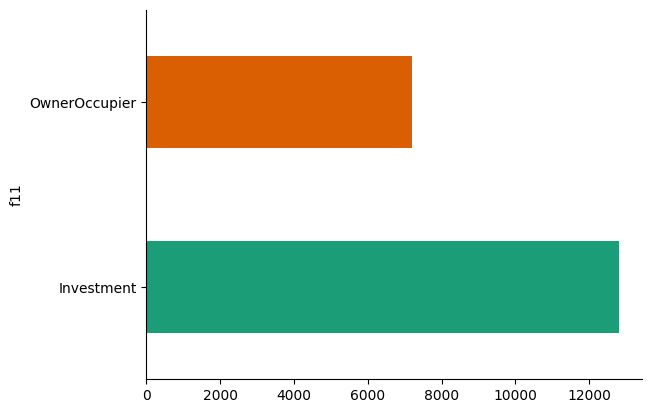

In [22]:
# @title f11

from matplotlib import pyplot as plt
import seaborn as sns
object_columns.groupby('f11').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Из даты достану год месяц и день. Есть предположение, что день скорее будет мешать, но по началу оставлю его как фичу

In [23]:
train_dropped['f1'] = pd.to_datetime(train_dropped['f1'], format='%d.%m.%Y')
train_dropped['year'] = train_dropped['f1'].dt.year
train_dropped['month'] = train_dropped['f1'].dt.month
train_dropped['day'] = train_dropped['f1'].dt.day
train_dropped.drop('f1', axis=1, inplace=True)

In [24]:
train_dropped.f154

0         9.70
1         1.67
2         7.42
3        11.01
4         4.46
         ...  
19994     0.00
19995     0.00
19996    16.43
19997    54.23
19998     2.09
Name: f154, Length: 19999, dtype: float64

In [25]:
train_dropped

f2    f4            f11                   f12           f13  \
0      37.0   5.0     Investment    Birjulevo Zapadnoe  8.464344e+06   
1      53.0  10.0     Investment              Tverskoe  7.307411e+06   
2      38.0  11.0     Investment       Beskudnikovskoe  3.292112e+06   
3      75.0   2.0  OwnerOccupier   Poselenie Sosenskoe  6.677245e+07   
4      35.0   6.0     Investment  Ochakovo-Matveevskoe  1.752651e+07   
...     ...   ...            ...                   ...           ...   
19994  45.0   3.0     Investment             Kuz'minki  7.984444e+06   
19995  48.0   3.0     Investment            Gol'janovo  1.428699e+07   
19996  52.0  11.0     Investment       Severnoe Butovo  8.889467e+06   
19997  27.0   3.0     Investment  Ochakovo-Matveevskoe  1.752651e+07   
19998  41.0   9.0     Investment           Dmitrovskoe  7.126815e+06   

            f14       f15       f16     f17  f19     f20  f22  f23  f25  f26  \
0       85721.0  0.075206  0.521867  5226.0  4.0  6149.0  4.0  0.0  0.0  0.0   
1       75377.0  0.065444  0.000078  4237.0  4.0  6398.0  4.0  1.0  3.0  2.0   
2       73148.0  0.063747  0.092291  4449.0  5.0  4346.0  5.0  0.0  1.0  0.0   
3        9553.0  0.336177  0.072158   656.0  0.0   629.0  0.0  0.0  0.0  0.0   
4      118843.0  0.133373  0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   
...         ...       ...       ...     ...  ...     ...  ...  ...  ...  ...   
19994  142243.0  0.372735  0.000995  7753.0  8.0  7651.0  8.0  1.0  1.0  0.0   
19995  157010.0  0.389354  0.194489  7751.0  6.0  8004.0  7.0  0.0  3.0  0.0   
19996   90114.0  0.579645  0.000000  5102.0  6.0  4798.0  6.0  0.0  2.0  0.0   
19997  118843.0  0.133373  0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   
19998   87713.0  0.125882  0.458174  4533.0  4.0  4439.0  4.0  0.0  1.0  0.0   

        f27   f28  f29   f30   f31    f32  f33  f34 f35  f36  f37  f38  f39  \
0       2.0   0.0   no   0.0   0.0    0.0  yes  yes  no  yes   no   no   no   
1      29.0  16.0  yes  10.0  23.0  141.0   no   no  no  yes  yes   no   no   
2       3.0   2.0   no   0.0   2.0    2.0   no   no  no   no   no   no   no   
3       1.0   0.0   no   0.0   0.0    1.0   no   no  no   no   no  yes   no   
4       7.0   3.0   no   0.0   6.0    4.0  yes   no  no   no   no   no   no   
...     ...   ...  ...   ...   ...    ...  ...  ...  ..  ...  ...  ...  ...   
19994   7.0   8.0   no   0.0   5.0    1.0   no   no  no  yes   no   no   no   
19995   5.0   3.0   no   0.0   5.0    3.0   no   no  no  yes   no   no   no   
19996   6.0   1.0   no   0.0   8.0    0.0   no   no  no   no   no   no   no   
19997   7.0   3.0   no   0.0   6.0    4.0  yes   no  no   no   no   no   no   
19998   6.0   2.0   no   0.0   5.0    1.0  yes   no  no   no   no   no  yes   

       f40       f41      f42      f43      f44     f45     f46      f47  \
0       no  145088.0  68858.0  76230.0  12273.0  6227.0  6046.0  54914.0   
1      yes  116742.0  52836.0  63906.0  11272.0  5470.0  5802.0  43921.0   
2       no   41504.0  18905.0  22599.0   9308.0  4847.0  4461.0  44449.0   
3       no   13890.0   6584.0   7307.0   1370.0   709.0   661.0   6127.0   
4       no  111023.0  53946.0  57077.0  16098.0  8287.0  7811.0  78670.0   
...    ...       ...      ...      ...      ...     ...     ...      ...   
19994   no   31167.0  16000.0  15167.0  16405.0  7985.0  8420.0  93811.0   
19995   no   12327.0   5588.0   6739.0  16831.0  8637.0  8194.0  98260.0   
19996   no   78616.0  35397.0  43219.0  10562.0  5371.0  5191.0  65270.0   
19997   no  111023.0  53946.0  57077.0  16098.0  8287.0  7811.0  78670.0   
19998   no  100846.0  46246.0  54600.0   9604.0  4946.0  4658.0  61600.0   

           f48      f49      f50      f51      f52     f53     f54     f55  \
0      27973.0  26941.0  18534.0   5391.0  13143.0  5226.0  2651.0  2575.0   
1      21901.0  22020.0  20184.0   6644.0  13540.0  4237.0  2079.0  2158.0   
2      22170.0  22279.0  19391.0   5955.0  13436.0  4449.0  2281.0  2168.0   
3       3

# Поскольку столбец f11 содержит только 2 уникальных значения Investment и OwnerOccupier а столбец f153 satisfactory,poor,no data,excellent,good - применю к ним onehot то есть dummy кодирование (no data намекает, что данных по этой фиче нет, но вроде как логично, что onehot создаст новый столбец и такому типу данных в столбце) - поскольку таких значений немного, размерность датасета сильно не повысится

In [26]:
encoder = OneHotEncoder(sparse=False)
nominal_features = ['f11', 'f153']
encoded_features = encoder.fit_transform(train_dropped[nominal_features])

In [27]:
encoded_feature_names = encoder.get_feature_names_out(nominal_features)
encoded_feature_names

array(['f11_Investment', 'f11_OwnerOccupier', 'f153_excellent',
       'f153_good', 'f153_no data', 'f153_poor', 'f153_satisfactory'],
      dtype=object)

In [28]:
train_dropped_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)
train_dropped = train_dropped.join(train_dropped_encoded)
train_dropped.drop(nominal_features, axis=1, inplace=True)

In [29]:
train_dropped

f2    f4                   f12           f13       f14       f15  \
0      37.0   5.0    Birjulevo Zapadnoe  8.464344e+06   85721.0  0.075206   
1      53.0  10.0              Tverskoe  7.307411e+06   75377.0  0.065444   
2      38.0  11.0       Beskudnikovskoe  3.292112e+06   73148.0  0.063747   
3      75.0   2.0   Poselenie Sosenskoe  6.677245e+07    9553.0  0.336177   
4      35.0   6.0  Ochakovo-Matveevskoe  1.752651e+07  118843.0  0.133373   
...     ...   ...                   ...           ...       ...       ...   
19994  45.0   3.0             Kuz'minki  7.984444e+06  142243.0  0.372735   
19995  48.0   3.0            Gol'janovo  1.428699e+07  157010.0  0.389354   
19996  52.0  11.0       Severnoe Butovo  8.889467e+06   90114.0  0.579645   
19997  27.0   3.0  Ochakovo-Matveevskoe  1.752651e+07  118843.0  0.133373   
19998  41.0   9.0           Dmitrovskoe  7.126815e+06   87713.0  0.125882   

            f16     f17  f19     f20  f22  f23  f25  f26   f27   f28  f29  \
0      0.521867  5226.0  4.0  6149.0  4.0  0.0  0.0  0.0   2.0   0.0   no   
1      0.000078  4237.0  4.0  6398.0  4.0  1.0  3.0  2.0  29.0  16.0  yes   
2      0.092291  4449.0  5.0  4346.0  5.0  0.0  1.0  0.0   3.0   2.0   no   
3      0.072158   656.0  0.0   629.0  0.0  0.0  0.0  0.0   1.0   0.0   no   
4      0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   7.0   3.0   no   
...         ...     ...  ...     ...  ...  ...  ...  ...   ...   ...  ...   
19994  0.000995  7753.0  8.0  7651.0  8.0  1.0  1.0  0.0   7.0   8.0   no   
19995  0.194489  7751.0  6.0  8004.0  7.0  0.0  3.0  0.0   5.0   3.0   no   
19996  0.000000  5102.0  6.0  4798.0  6.0  0.0  2.0  0.0   6.0   1.0   no   
19997  0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   7.0   3.0   no   
19998  0.458174  4533.0  4.0  4439.0  4.0  0.0  1.0  0.0   6.0   2.0   no   

        f30   f31    f32  f33  f34 f35  f36  f37  f38  f39  f40       f41  \
0       0.0   0.0    0.0  yes  yes  no  yes   no   no   no   no  145088.0   
1      10.0  23.0  141.0   no   no  no  yes  yes   no   no  yes  116742.0   
2       0.0   2.0    2.0   no   no  no   no   no   no   no   no   41504.0   
3       0.0   0.0    1.0   no   no  no   no   no  yes   no   no   13890.0   
4       0.0   6.0    4.0  yes   no  no   no   no   no   no   no  111023.0   
...     ...   ...    ...  ...  ...  ..  ...  ...  ...  ...  ...       ...   
19994   0.0   5.0    1.0   no   no  no  yes   no   no   no   no   31167.0   
19995   0.0   5.0    3.0   no   no  no  yes   no   no   no   no   12327.0   
19996   0.0   8.0    0.0   no   no  no   no   no   no   no   no   78616.0   
19997   0.0   6.0    4.0  yes   no  no   no   no   no   no   no  111023.0   
19998   0.0   5.0    1.0  yes   no  no   no   no   no  yes   no  100846.0   

           f42      f43      f44     f45     f46      f47      f48      f49  \
0      68858.0  76230.0  12273.0  6227.0  6046.0  54914.0  27973.0  26941.0   
1      52836.0  63906.0  11272.0  5470.0  5802.0  43921.0  21901.0  22020.0   
2      18905.0  22599.0   9308.0  4847.0  4461.0  44449.0  22170.0  22279.0   
3       6584.0   7307.0   1370.0   709.0   661.0   6127.0   3237.0   2890.0   
4      53946.0  57077.0  16098.0  8287.0  7811.0  78670.0  44653.0  34017.0   
...        ...      ...      ...     ...     ...      ...      ...      ...   
19994  16000.0  15167.0  16405.0  7985.0  8420.0  93811.0  46746.0  47065.0   
19995   5588.0   6739.0  16831.0  8637.0  8194.0  98260.0  47405.0  50855.0   
19996  35397.0  43219.0  10562.0  5371.0  5191.0  65270.0  38289.0  26981.0   
19997  53946.0  57077.0  16098.0  8287.0  7811.0  78670.0  44653.0  34017.0   
19998  46246.0  54600.0   9604.0  4946.0  4658.0  61600.0  31908.0  29692.0   

           f50      f51      f52     f53     f54     f55     f56     f57  \
0      18534.0   5391.0  13143.0  5226.0  2651.0  2575.0  6149.0  3091.0   
1      20184.0   6644.0  13540.0  4237.0  2079.0  2158.0  6398.0  3094.0   
2      19391.0   5955.0  13436.0  4449.0  2281.0  2168.0 

# Бинарные переменные опять кодирую, но чтобы не плодить дополнительные столбцы, перекодирую своими силами внутри столбца с помощью лямбда функции, а столбец f75 выкину, там все значения уникальные

In [30]:
binary_features = ['f29', 'f33', 'f34', 'f115', 'f119' , 'f35' ,	'f36',	'f37' ,	'f38' ,	'f39' , 'f40' , 'f107']
train_dropped[binary_features] = train_dropped[binary_features].applymap(lambda x: 1 if x == 'yes' else 0)

In [31]:
train_dropped.drop(['f75'], axis=1, inplace=True)

In [32]:
train_dropped

f2    f4                   f12           f13       f14       f15  \
0      37.0   5.0    Birjulevo Zapadnoe  8.464344e+06   85721.0  0.075206   
1      53.0  10.0              Tverskoe  7.307411e+06   75377.0  0.065444   
2      38.0  11.0       Beskudnikovskoe  3.292112e+06   73148.0  0.063747   
3      75.0   2.0   Poselenie Sosenskoe  6.677245e+07    9553.0  0.336177   
4      35.0   6.0  Ochakovo-Matveevskoe  1.752651e+07  118843.0  0.133373   
...     ...   ...                   ...           ...       ...       ...   
19994  45.0   3.0             Kuz'minki  7.984444e+06  142243.0  0.372735   
19995  48.0   3.0            Gol'janovo  1.428699e+07  157010.0  0.389354   
19996  52.0  11.0       Severnoe Butovo  8.889467e+06   90114.0  0.579645   
19997  27.0   3.0  Ochakovo-Matveevskoe  1.752651e+07  118843.0  0.133373   
19998  41.0   9.0           Dmitrovskoe  7.126815e+06   87713.0  0.125882   

            f16     f17  f19     f20  f22  f23  f25  f26   f27   f28  f29  \
0      0.521867  5226.0  4.0  6149.0  4.0  0.0  0.0  0.0   2.0   0.0    0   
1      0.000078  4237.0  4.0  6398.0  4.0  1.0  3.0  2.0  29.0  16.0    1   
2      0.092291  4449.0  5.0  4346.0  5.0  0.0  1.0  0.0   3.0   2.0    0   
3      0.072158   656.0  0.0   629.0  0.0  0.0  0.0  0.0   1.0   0.0    0   
4      0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   7.0   3.0    0   
...         ...     ...  ...     ...  ...  ...  ...  ...   ...   ...  ...   
19994  0.000995  7753.0  8.0  7651.0  8.0  1.0  1.0  0.0   7.0   8.0    0   
19995  0.194489  7751.0  6.0  8004.0  7.0  0.0  3.0  0.0   5.0   3.0    0   
19996  0.000000  5102.0  6.0  4798.0  6.0  0.0  2.0  0.0   6.0   1.0    0   
19997  0.309479  7454.0  2.0  7715.0  3.0  0.0  0.0  0.0   7.0   3.0    0   
19998  0.458174  4533.0  4.0  4439.0  4.0  0.0  1.0  0.0   6.0   2.0    0   

        f30   f31    f32  f33  f34  f35  f36  f37  f38  f39  f40       f41  \
0       0.0   0.0    0.0    1    1    0    1    0    0    0    0  145088.0   
1      10.0  23.0  141.0    0    0    0    1    1    0    0    1  116742.0   
2       0.0   2.0    2.0    0    0    0    0    0    0    0    0   41504.0   
3       0.0   0.0    1.0    0    0    0    0    0    1    0    0   13890.0   
4       0.0   6.0    4.0    1    0    0    0    0    0    0    0  111023.0   
...     ...   ...    ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
19994   0.0   5.0    1.0    0    0    0    1    0    0    0    0   31167.0   
19995   0.0   5.0    3.0    0    0    0    1    0    0    0    0   12327.0   
19996   0.0   8.0    0.0    0    0    0    0    0    0    0    0   78616.0   
19997   0.0   6.0    4.0    1    0    0    0    0    0    0    0  111023.0   
19998   0.0   5.0    1.0    1    0    0    0    0    0    1    0  100846.0   

           f42      f43      f44     f45     f46      f47      f48      f49  \
0      68858.0  76230.0  12273.0  6227.0  6046.0  54914.0  27973.0  26941.0   
1      52836.0  63906.0  11272.0  5470.0  5802.0  43921.0  21901.0  22020.0   
2      18905.0  22599.0   9308.0  4847.0  4461.0  44449.0  22170.0  22279.0   
3       6584.0   7307.0   1370.0   709.0   661.0   6127.0   3237.0   2890.0   
4      53946.0  57077.0  16098.0  8287.0  7811.0  78670.0  44653.0  34017.0   
...        ...      ...      ...     ...     ...      ...      ...      ...   
19994  16000.0  15167.0  16405.0  7985.0  8420.0  93811.0  46746.0  47065.0   
19995   5588.0   6739.0  16831.0  8637.0  8194.0  98260.0  47405.0  50855.0   
19996  35397.0  43219.0  10562.0  5371.0  5191.0  65270.0  38289.0  26981.0   
19997  53946.0  57077.0  16098.0  8287.0  7811.0  78670.0  44653.0  34017.0   
19998  46246.0  54600.0   9604.0  4946.0  4658.0  61600.0  31908.0  29692.0   

           f50      f51      f52     f53     f54     f55     f56     f57  \
0      18534.0   5391.0  13143.0  5226.0  2651.0  2575.0  6149.0  3091.0   
1      20184.0   6644.0  13540.0  4237.0  2079.0  2158.0  6398.0  3094.0   
2      19391.0   5955.0  13436.0  4449.0  228

# Принцип работы FeatureHasher основан на хэшировании признаков. Он использует хэш-функцию для преобразования каждого признака в индекс вектора фиксированной длины. Это позволяет эффективно уменьшить размерность данных и ускорить вычисления, хотя иногда может привести к конфликтам хэшей (различные признаки могут быть преобразованы в один и тот же индекс). Скупой ответ из интернета. Но как я понял это полезная штука для работы со столбцами где есть геоданные и не только

In [33]:
hasher = FeatureHasher(n_features=10, input_type='string')

In [34]:
hashed_features = hasher.fit_transform(train_dropped['f12'].astype(str).apply(lambda x: [x]))

In [35]:
hashed_features_df = pd.DataFrame(hashed_features.toarray())

In [36]:
hashed_feature_names = [f'f12_hashed_{i}' for i in range(hashed_features_df.shape[1])]

In [37]:
hashed_features_df.columns = hashed_feature_names

In [38]:
train_dropped = pd.concat([train_dropped.drop('f12', axis=1), hashed_features_df], axis=1)

# От категориальных фич избавились, теперь нужно заменить остатки пропущенных значений. По классике использую меидану

In [39]:
train_dropped.dtypes

f2                   float64
f4                   float64
f13                  float64
f14                  float64
f15                  float64
f16                  float64
f17                  float64
f19                  float64
f20                  float64
f22                  float64
f23                  float64
f25                  float64
f26                  float64
f27                  float64
f28                  float64
f29                    int64
f30                  float64
f31                  float64
f32                  float64
f33                    int64
f34                    int64
f35                    int64
f36                    int64
f37                    int64
f38                    int64
f39                    int64
f40                    int64
f41                  float64
f42                  float64
f43                  float64
f44                  float64
f45                  float64
f46                  float64
f47                  float64
f48           

In [40]:
medians = train_dropped.median()
medians

f2                   5.000000e+01
f4                   7.000000e+00
f13                  1.041657e+07
f14                  8.384400e+04
f15                  1.675257e-01
f16                  7.542368e-02
f17                  4.857000e+03
f19                  4.000000e+00
f20                  5.261000e+03
f22                  5.000000e+00
f23                  0.000000e+00
f25                  1.000000e+00
f26                  0.000000e+00
f27                  5.000000e+00
f28                  2.000000e+00
f29                  0.000000e+00
f30                  0.000000e+00
f31                  3.000000e+00
f32                  2.000000e+00
f33                  0.000000e+00
f34                  0.000000e+00
f35                  0.000000e+00
f36                  0.000000e+00
f37                  0.000000e+00
f38                  0.000000e+00
f39                  0.000000e+00
f40                  0.000000e+00
f41                  8.521900e+04
f42                  3.926100e+04
f43           

In [41]:
train_dropped.fillna(medians, inplace=True)

# И еще попробую фичу для уменьшения размерности  - отсею по корреляции

In [42]:
correlation_matrix = train_dropped.corr()
target_correlation = correlation_matrix['target'].sort_values(ascending=False)

In [43]:
low_correlation_features = target_correlation[abs(target_correlation) < 0.1].index.tolist()
print("\nLow correlation features:", low_correlation_features)
len(low_correlation_features)


Low correlation features: ['f219', 'f165', 'f238', 'f205', 'f191', 'f242', 'f265', 'f270', 'f243', 'f241', 'f121', 'f194', 'f188', 'f222', 'f153_poor', 'f168', 'f240', 'f153_excellent', 'f196', 'f181', 'f169', 'f218', 'f215', 'f199', 'f158', 'f217', 'f170', 'f12_hashed_0', 'f12_hashed_5', 'f115', 'f37', 'f195', 'f164', 'f12_hashed_3', 'f95', 'f85', 'f28', 'f94', 'f176', 'f30', 'f182', 'f192', 'f40', 'f33', 'f277', 'f278', 'f276', 'f42', 'f41', 'f39', 'f43', 'f171', 'f63', 'f62', 'f64', 'f247', 'f172', 'day', 'f173', 'f253', 'f159', 'f255', 'f254', 'f12_hashed_8', 'f155', 'f153_good', 'f12_hashed_2', 'f12_hashed_9', 'f119', 'f108', 'month', 'f96', 'f35', 'f106', 'f12_hashed_1', 'f12_hashed_7', 'f107', 'f100', 'f130', 'f224', 'f123', 'f103', 'f154', 'f178', 'f177', 'f93', 'f201', 'f97', 'f114', 'f12_hashed_4', 'f38', 'f12_hashed_6', 'f117', 'f16', 'f34', 'f200', 'f118', 'f15']


98

In [44]:
train_dropped = train_dropped.drop(columns=low_correlation_features)

In [45]:
train_dropped.isna().sum()

f2                   0
f4                   0
f13                  0
f14                  0
f17                  0
f19                  0
f20                  0
f22                  0
f23                  0
f25                  0
f26                  0
f27                  0
f29                  0
f31                  0
f32                  0
f36                  0
f44                  0
f45                  0
f46                  0
f47                  0
f48                  0
f49                  0
f50                  0
f51                  0
f52                  0
f53                  0
f54                  0
f55                  0
f56                  0
f57                  0
f58                  0
f59                  0
f60                  0
f61                  0
f65                  0
f66                  0
f67                  0
f86                  0
f87                  0
f88                  0
f89                  0
f90                  0
f91                  0
f92        

# Делю на таргет и регрессоры

In [46]:
X = train_dropped.drop('target', axis=1)
y = train_dropped['target']

In [47]:
X

f2    f4           f13       f14     f17  f19     f20  f22  f23  f25  \
0      37.0   5.0  8.464344e+06   85721.0  5226.0  4.0  6149.0  4.0  0.0  0.0   
1      53.0  10.0  7.307411e+06   75377.0  4237.0  4.0  6398.0  4.0  1.0  3.0   
2      38.0  11.0  3.292112e+06   73148.0  4449.0  5.0  4346.0  5.0  0.0  1.0   
3      75.0   2.0  6.677245e+07    9553.0   656.0  0.0   629.0  0.0  0.0  0.0   
4      35.0   6.0  1.752651e+07  118843.0  7454.0  2.0  7715.0  3.0  0.0  0.0   
...     ...   ...           ...       ...     ...  ...     ...  ...  ...  ...   
19994  45.0   3.0  7.984444e+06  142243.0  7753.0  8.0  7651.0  8.0  1.0  1.0   
19995  48.0   3.0  1.428699e+07  157010.0  7751.0  6.0  8004.0  7.0  0.0  3.0   
19996  52.0  11.0  8.889467e+06   90114.0  5102.0  6.0  4798.0  6.0  0.0  2.0   
19997  27.0   3.0  1.752651e+07  118843.0  7454.0  2.0  7715.0  3.0  0.0  0.0   
19998  41.0   9.0  7.126815e+06   87713.0  4533.0  4.0  4439.0  4.0  0.0  1.0   

       f26   f27  f29   f31    f32  f36      f44     f45     f46      f47  \
0      0.0   2.0    0   0.0    0.0    1  12273.0  6227.0  6046.0  54914.0   
1      2.0  29.0    1  23.0  141.0    1  11272.0  5470.0  5802.0  43921.0   
2      0.0   3.0    0   2.0    2.0    0   9308.0  4847.0  4461.0  44449.0   
3      0.0   1.0    0   0.0    1.0    0   1370.0   709.0   661.0   6127.0   
4      0.0   7.0    0   6.0    4.0    0  16098.0  8287.0  7811.0  78670.0   
...    ...   ...  ...   ...    ...  ...      ...     ...     ...      ...   
19994  0.0   7.0    0   5.0    1.0    1  16405.0  7985.0  8420.0  93811.0   
19995  0.0   5.0    0   5.0    3.0    1  16831.0  8637.0  8194.0  98260.0   
19996  0.0   6.0    0   8.0    0.0    0  10562.0  5371.0  5191.0  65270.0   
19997  0.0   7.0    0   6.0    4.0    0  16098.0  8287.0  7811.0  78670.0   
19998  0.0   6.0    0   5.0    1.0    0   9604.0  4946.0  4658.0  61600.0   

           f48      f49      f50      f51      f52     f53     f54     f55  \
0      27973.0  26941.0  18534.0   5391.0  13143.0  5226.0  2651.0  2575.0   
1      21901.0  22020.0  20184.0   6644.0  13540.0  4237.0  2079.0  2158.0   
2      22170.0  22279.0  19391.0   5955.0  13436.0  4449.0  2281.0  2168.0   
3       3237.0   2890.0   2056.0    583.0   1473.0   656.0   340.0   316.0   
4      44653.0  34017.0  24075.0   7300.0  16775.0  7454.0  3845.0  3609.0   
...        ...      ...      ...      ...      ...     ...     ...     ...   
19994  46746.0  47065.0  32027.0   8404.0  23623.0  7753.0  3809.0  3944.0   
19995  47405.0  50855.0  41919.0  12424.0  29495.0  7751.0  3941.0  3810.0   
19996  38289.0  26981.0  14282.0   4233.0  10049.0  5102.0  2574.0  2528.0   
19997  44653.0  34017.0  24075.0   7300.0  16775.0  7454.0  3845.0  3609.0   
19998  31908.0  29692.0  16509.0   4434.0  12075.0  4533.0  2319.0  2214.0   

          f56     f57     f58      f59     f60     f61      f65     f66  \
0      6149.0  3091.0  3058.0  14031.0  7081.0  6950.0  10513.0  5272.0   
1      6398.0  3094.0  3304.0  12508.0  6065.0  6443.0   9955.0  4835.0   
2      4346.0  2283.0  2063.0  10271.0  5360.0  4911.0   8322.0  4322.0   
3       629.0   325.0   305.0   1542.0   801.0   742.0   1207.0   623.0   
4      7715.0  3971.0  3744.0  18269.0  9507.0  8762.0  14168.0  7326.0   
...       ...     ...     ...      ...     ...     ...      ...     ...   
19994  7651.0  3675.0  3976.0  18245.0  8914.0  9331.0  14430.0  7004.0   
19995  8004.0  4152.0  3852.0  18912.0  9716.0  9196.0  14694.0  7551.0   
19996  4798.0  2468.0  2330.0  11749.0  5983.0  5766.0   9304.0  4727.0   
19997  7715.0  3971.0  3744.0  18269.0  9507.0  8762.0  14168.0  7326.0   
19998  4439.0  2273.0  2166.0  10797.0  5557.0  5240.0   8382.0  4287.0   

          f67       f86       f87        f88       f89       f90       f91  \
0      5241.0  6.658569  5.956633  73.393444  6.116120  0.493450  0.598885   
1      5120.0  2.566780  1.323536   9.061148  0.755096  0.210380  0.169143   
2      4000.0  2.204105  0.916737  11.0

# Понятное дело, данные нужно нормализовать. Насколько я знаю, есть два варианта - самому отнормализовать и в нейронку передавать уже заскеленные данные либо использовать батчнормализацию. Как трушный фанат ML я буду сам использовать скалеры и потом страдать при работе с x_test

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [49]:
X_scaled

array([[-0.39353779, -0.50256557, -0.44161464, ..., -0.74945969,
        -0.57567587,  2.71953779],
       [-0.03053254,  0.43966831, -0.49696153, ..., -0.74945969,
        -0.57567587, -0.36770954],
       [-0.37084996,  0.62811509, -0.68905061, ..., -0.74945969,
        -0.57567587, -0.36770954],
       ...,
       [-0.05322036,  0.62811509, -0.42127706, ..., -0.74945969,
        -0.57567587, -0.36770954],
       [-0.62041607, -0.87945912, -0.00808711, ..., -0.74945969,
        -0.57567587,  2.71953779],
       [-0.30278647,  0.25122154, -0.50560108, ..., -0.74945969,
        -0.57567587, -0.36770954]])

In [50]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Делаю тензоры, о да, нейронки

In [51]:
X_tensor = torch.tensor(X_scaled_df.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [52]:
X_tensor

tensor([[-0.3935, -0.5026, -0.4416,  ..., -0.7495, -0.5757,  2.7195],
        [-0.0305,  0.4397, -0.4970,  ..., -0.7495, -0.5757, -0.3677],
        [-0.3708,  0.6281, -0.6891,  ..., -0.7495, -0.5757, -0.3677],
        ...,
        [-0.0532,  0.6281, -0.4213,  ..., -0.7495, -0.5757, -0.3677],
        [-0.6204, -0.8795, -0.0081,  ..., -0.7495, -0.5757,  2.7195],
        [-0.3028,  0.2512, -0.5056,  ..., -0.7495, -0.5757, -0.3677]])

In [53]:
y_tensor

tensor([ 4900000., 13500000.,  6100000.,  ...,  2000000.,  1500000.,
         1000000.])

In [54]:
dataset = TensorDataset(X_tensor, y_tensor)
dataset

In [55]:
dataloader = DataLoader(dataset, batch_size = 128, shuffle=True)

In [56]:
X_tensor.shape[1]

173

# Шаг 2. Построить autoencoder для сокращения размерности признаков

In [57]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, encoding_dim),
            nn.ReLU(True),
            nn.Dropout(0.1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(128),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Параметры для обучения автоэнкодера

In [58]:
input_dim = X_tensor.shape[1]
encoding_dim = 32
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Переключаюсь на гпушку

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Обучаю автоэнкодер

In [60]:
num_epochs = 50
for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.5431
Epoch [2/50], Loss: 0.8643
Epoch [3/50], Loss: 0.3919
Epoch [4/50], Loss: 0.3743
Epoch [5/50], Loss: 0.5662
Epoch [6/50], Loss: 0.4357
Epoch [7/50], Loss: 1.1250
Epoch [8/50], Loss: 0.3350
Epoch [9/50], Loss: 0.3990
Epoch [10/50], Loss: 0.4278
Epoch [11/50], Loss: 0.8242
Epoch [12/50], Loss: 0.3280
Epoch [13/50], Loss: 0.2771
Epoch [14/50], Loss: 0.5418
Epoch [15/50], Loss: 0.3959
Epoch [16/50], Loss: 0.5456
Epoch [17/50], Loss: 0.6341
Epoch [18/50], Loss: 1.0393
Epoch [19/50], Loss: 0.3751
Epoch [20/50], Loss: 0.5541
Epoch [21/50], Loss: 0.7592
Epoch [22/50], Loss: 0.3571
Epoch [23/50], Loss: 0.5346
Epoch [24/50], Loss: 0.4224
Epoch [25/50], Loss: 0.3672
Epoch [26/50], Loss: 0.7246
Epoch [27/50], Loss: 0.6088
Epoch [28/50], Loss: 0.3712
Epoch [29/50], Loss: 0.6099
Epoch [30/50], Loss: 1.0308
Epoch [31/50], Loss: 0.5296
Epoch [32/50], Loss: 0.3758
Epoch [33/50], Loss: 0.5855
Epoch [34/50], Loss: 0.3123
Epoch [35/50], Loss: 0.5634
Epoch [36/50], Loss: 0.3178
E

# Использую его для преобразования данных через энкодер

In [61]:
class Encoder(nn.Module):
    def __init__(self, trained_autoencoder):
        super(Encoder, self).__init__()
        self.encoder = trained_autoencoder.encoder

    def forward(self, x):
        return self.encoder(x)

encoder_model = Encoder(model)

In [62]:
encoded_features = model.encoder(X_tensor).detach().numpy()

In [63]:
encoded_features

array([[0.        , 0.        , 0.6197415 , ..., 0.2095015 , 0.4955676 ,
        1.7701795 ],
       [0.        , 4.595131  , 0.        , ..., 2.6263747 , 0.        ,
        0.        ],
       [0.        , 0.45519143, 0.6804481 , ..., 0.        , 1.6544533 ,
        0.        ],
       ...,
       [0.        , 0.8705895 , 3.3545527 , ..., 0.34498647, 0.4100269 ,
        0.29539412],
       [1.2102851 , 0.        , 0.        , ..., 0.        , 0.        ,
        3.797134  ],
       [0.        , 0.38299254, 2.6334975 , ..., 1.4158188 , 1.8038385 ,
        4.0975213 ]], dtype=float32)

# Определяю нейросеть для предсказания таргета

In [64]:
class FCNN(nn.Module):
    def __init__(self, input_dim):
        super(FCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),

            nn.Linear(32, 16),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

# Задаю функцию для расчета MSLE - целевой метрики

In [65]:
def msle_loss(y_pred, y_true):
    return torch.mean((torch.log1p(y_pred) - torch.log1p(y_true)) ** 2)

# Использую Adam оптимизатор

In [66]:
model = FCNN(input_dim=X_tensor.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Буду использовать небольшие батчи

In [67]:
dataset = TensorDataset(X_tensor, y_tensor.view(-1, 1))
dataloader = DataLoader(dataset, batch_size = 128, shuffle=True)

In [68]:
model = model.to(device)

# Обучаю нейроесть

In [69]:
num_epochs = 100
for epoch in tqdm(range(num_epochs), desc="Training epochs"):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = msle_loss(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

Training epochs:   1%|          | 1/100 [00:00<01:31,  1.08it/s]

Epoch [1/100], Loss: 1.1772701740264893


Training epochs:   2%|▏         | 2/100 [00:01<01:16,  1.29it/s]

Epoch [2/100], Loss: 0.5898053646087646


Training epochs:   3%|▎         | 3/100 [00:02<01:12,  1.34it/s]

Epoch [3/100], Loss: 0.7494402527809143


Training epochs:   4%|▍         | 4/100 [00:02<01:09,  1.39it/s]

Epoch [4/100], Loss: 0.4049144983291626


Training epochs:   5%|▌         | 5/100 [00:03<01:06,  1.43it/s]

Epoch [5/100], Loss: 0.29028794169425964


Training epochs:   6%|▌         | 6/100 [00:04<01:04,  1.45it/s]

Epoch [6/100], Loss: 0.42435234785079956


Training epochs:   7%|▋         | 7/100 [00:04<01:03,  1.46it/s]

Epoch [7/100], Loss: 0.23445744812488556


Training epochs:   8%|▊         | 8/100 [00:05<01:02,  1.48it/s]

Epoch [8/100], Loss: 0.5132030844688416


Training epochs:   9%|▉         | 9/100 [00:06<01:02,  1.46it/s]

Epoch [9/100], Loss: 0.14954249560832977


Training epochs:  10%|█         | 10/100 [00:07<01:01,  1.47it/s]

Epoch [10/100], Loss: 0.12827523052692413


Training epochs:  11%|█         | 11/100 [00:07<01:04,  1.37it/s]

Epoch [11/100], Loss: 0.48878300189971924


Training epochs:  12%|█▏        | 12/100 [00:08<01:08,  1.29it/s]

Epoch [12/100], Loss: 0.27462321519851685


Training epochs:  13%|█▎        | 13/100 [00:09<01:13,  1.19it/s]

Epoch [13/100], Loss: 0.3621165156364441


Training epochs:  14%|█▍        | 14/100 [00:10<01:08,  1.26it/s]

Epoch [14/100], Loss: 0.2928442656993866


Training epochs:  15%|█▌        | 15/100 [00:11<01:04,  1.31it/s]

Epoch [15/100], Loss: 0.48024287819862366


Training epochs:  16%|█▌        | 16/100 [00:11<01:01,  1.36it/s]

Epoch [16/100], Loss: 0.14838279783725739


Training epochs:  17%|█▋        | 17/100 [00:12<00:59,  1.39it/s]

Epoch [17/100], Loss: 0.10529173165559769


Training epochs:  18%|█▊        | 18/100 [00:13<00:58,  1.40it/s]

Epoch [18/100], Loss: 0.23688632249832153


Training epochs:  19%|█▉        | 19/100 [00:13<00:57,  1.42it/s]

Epoch [19/100], Loss: 0.3238793611526489


Training epochs:  20%|██        | 20/100 [00:14<00:55,  1.43it/s]

Epoch [20/100], Loss: 0.29869553446769714


Training epochs:  21%|██        | 21/100 [00:15<00:54,  1.45it/s]

Epoch [21/100], Loss: 0.18827591836452484


Training epochs:  22%|██▏       | 22/100 [00:15<00:53,  1.47it/s]

Epoch [22/100], Loss: 0.2929452657699585


Training epochs:  23%|██▎       | 23/100 [00:16<00:52,  1.47it/s]

Epoch [23/100], Loss: 0.16297884285449982


Training epochs:  24%|██▍       | 24/100 [00:17<00:51,  1.49it/s]

Epoch [24/100], Loss: 0.20237547159194946


Training epochs:  25%|██▌       | 25/100 [00:17<00:50,  1.48it/s]

Epoch [25/100], Loss: 0.16681912541389465


Training epochs:  26%|██▌       | 26/100 [00:18<00:50,  1.48it/s]

Epoch [26/100], Loss: 0.08675296604633331


Training epochs:  27%|██▋       | 27/100 [00:19<00:49,  1.49it/s]

Epoch [27/100], Loss: 0.12831372022628784


Training epochs:  28%|██▊       | 28/100 [00:19<00:49,  1.45it/s]

Epoch [28/100], Loss: 0.07226697355508804


Training epochs:  29%|██▉       | 29/100 [00:20<00:53,  1.33it/s]

Epoch [29/100], Loss: 0.3842853903770447


Training epochs:  30%|███       | 30/100 [00:21<00:56,  1.23it/s]

Epoch [30/100], Loss: 0.2038901299238205


Training epochs:  31%|███       | 31/100 [00:22<00:55,  1.23it/s]

Epoch [31/100], Loss: 0.35742488503456116


Training epochs:  32%|███▏      | 32/100 [00:23<00:51,  1.31it/s]

Epoch [32/100], Loss: 0.17372870445251465


Training epochs:  33%|███▎      | 33/100 [00:23<00:49,  1.36it/s]

Epoch [33/100], Loss: 0.17261458933353424


Training epochs:  34%|███▍      | 34/100 [00:24<00:47,  1.40it/s]

Epoch [34/100], Loss: 0.15167075395584106


Training epochs:  35%|███▌      | 35/100 [00:25<00:45,  1.42it/s]

Epoch [35/100], Loss: 0.2952253222465515


Training epochs:  36%|███▌      | 36/100 [00:25<00:44,  1.44it/s]

Epoch [36/100], Loss: 0.18457049131393433


Training epochs:  37%|███▋      | 37/100 [00:26<00:43,  1.46it/s]

Epoch [37/100], Loss: 0.14537712931632996


Training epochs:  38%|███▊      | 38/100 [00:27<00:42,  1.47it/s]

Epoch [38/100], Loss: 0.27822741866111755


Training epochs:  39%|███▉      | 39/100 [00:27<00:41,  1.49it/s]

Epoch [39/100], Loss: 0.12526759505271912


Training epochs:  40%|████      | 40/100 [00:28<00:40,  1.48it/s]

Epoch [40/100], Loss: 0.27195388078689575


Training epochs:  41%|████      | 41/100 [00:29<00:39,  1.49it/s]

Epoch [41/100], Loss: 0.1725815236568451


Training epochs:  42%|████▏     | 42/100 [00:29<00:38,  1.50it/s]

Epoch [42/100], Loss: 0.18343138694763184


Training epochs:  43%|████▎     | 43/100 [00:30<00:38,  1.49it/s]

Epoch [43/100], Loss: 0.17605198919773102


Training epochs:  44%|████▍     | 44/100 [00:31<00:37,  1.50it/s]

Epoch [44/100], Loss: 0.26916250586509705


Training epochs:  45%|████▌     | 45/100 [00:31<00:36,  1.49it/s]

Epoch [45/100], Loss: 0.5270947813987732


Training epochs:  46%|████▌     | 46/100 [00:32<00:38,  1.39it/s]

Epoch [46/100], Loss: 0.1486889123916626


Training epochs:  47%|████▋     | 47/100 [00:33<00:40,  1.30it/s]

Epoch [47/100], Loss: 0.15764449536800385


Training epochs:  48%|████▊     | 48/100 [00:34<00:43,  1.19it/s]

Epoch [48/100], Loss: 0.13398797810077667


Training epochs:  49%|████▉     | 49/100 [00:35<00:40,  1.27it/s]

Epoch [49/100], Loss: 0.15921257436275482


Training epochs:  50%|█████     | 50/100 [00:36<00:37,  1.33it/s]

Epoch [50/100], Loss: 0.39461368322372437


Training epochs:  51%|█████     | 51/100 [00:36<00:35,  1.38it/s]

Epoch [51/100], Loss: 0.35930848121643066


Training epochs:  52%|█████▏    | 52/100 [00:37<00:33,  1.41it/s]

Epoch [52/100], Loss: 0.21531517803668976


Training epochs:  53%|█████▎    | 53/100 [00:38<00:36,  1.29it/s]

Epoch [53/100], Loss: 0.11388401687145233


Training epochs:  54%|█████▍    | 54/100 [00:39<00:37,  1.24it/s]

Epoch [54/100], Loss: 0.30787885189056396


Training epochs:  55%|█████▌    | 55/100 [00:39<00:34,  1.31it/s]

Epoch [55/100], Loss: 0.1706579625606537


Training epochs:  56%|█████▌    | 56/100 [00:40<00:32,  1.36it/s]

Epoch [56/100], Loss: 0.10824395716190338


Training epochs:  57%|█████▋    | 57/100 [00:41<00:30,  1.40it/s]

Epoch [57/100], Loss: 0.13712510466575623


Training epochs:  58%|█████▊    | 58/100 [00:41<00:29,  1.43it/s]

Epoch [58/100], Loss: 0.1470748484134674


Training epochs:  59%|█████▉    | 59/100 [00:42<00:28,  1.45it/s]

Epoch [59/100], Loss: 0.4559120535850525


Training epochs:  60%|██████    | 60/100 [00:43<00:27,  1.45it/s]

Epoch [60/100], Loss: 0.34418392181396484


Training epochs:  61%|██████    | 61/100 [00:43<00:26,  1.48it/s]

Epoch [61/100], Loss: 0.24438270926475525


Training epochs:  62%|██████▏   | 62/100 [00:44<00:27,  1.38it/s]

Epoch [62/100], Loss: 0.2837522625923157


Training epochs:  63%|██████▎   | 63/100 [00:45<00:31,  1.18it/s]

Epoch [63/100], Loss: 0.08285987377166748


Training epochs:  64%|██████▍   | 64/100 [00:46<00:32,  1.10it/s]

Epoch [64/100], Loss: 0.2183775007724762


Training epochs:  65%|██████▌   | 65/100 [00:48<00:34,  1.00it/s]

Epoch [65/100], Loss: 0.21846038103103638


Training epochs:  66%|██████▌   | 66/100 [00:48<00:32,  1.04it/s]

Epoch [66/100], Loss: 0.2805933356285095


Training epochs:  67%|██████▋   | 67/100 [00:49<00:28,  1.15it/s]

Epoch [67/100], Loss: 0.11877761036157608


Training epochs:  68%|██████▊   | 68/100 [00:50<00:25,  1.24it/s]

Epoch [68/100], Loss: 0.5917928218841553


Training epochs:  69%|██████▉   | 69/100 [00:50<00:23,  1.30it/s]

Epoch [69/100], Loss: 0.6182962656021118


Training epochs:  70%|███████   | 70/100 [00:51<00:22,  1.36it/s]

Epoch [70/100], Loss: 0.1498880684375763


Training epochs:  71%|███████   | 71/100 [00:52<00:20,  1.40it/s]

Epoch [71/100], Loss: 0.21579866111278534


Training epochs:  72%|███████▏  | 72/100 [00:52<00:19,  1.42it/s]

Epoch [72/100], Loss: 0.16350729763507843


Training epochs:  73%|███████▎  | 73/100 [00:53<00:18,  1.44it/s]

Epoch [73/100], Loss: 0.21365073323249817


Training epochs:  74%|███████▍  | 74/100 [00:54<00:17,  1.46it/s]

Epoch [74/100], Loss: 0.15515492856502533


Training epochs:  75%|███████▌  | 75/100 [00:54<00:16,  1.48it/s]

Epoch [75/100], Loss: 0.2823704779148102


Training epochs:  76%|███████▌  | 76/100 [00:55<00:16,  1.49it/s]

Epoch [76/100], Loss: 0.16503684222698212


Training epochs:  77%|███████▋  | 77/100 [00:56<00:15,  1.49it/s]

Epoch [77/100], Loss: 0.2820587754249573


Training epochs:  78%|███████▊  | 78/100 [00:56<00:14,  1.49it/s]

Epoch [78/100], Loss: 0.19442307949066162


Training epochs:  79%|███████▉  | 79/100 [00:57<00:14,  1.50it/s]

Epoch [79/100], Loss: 0.07981846481561661


Training epochs:  80%|████████  | 80/100 [00:58<00:13,  1.50it/s]

Epoch [80/100], Loss: 0.35145026445388794


Training epochs:  81%|████████  | 81/100 [00:59<00:13,  1.41it/s]

Epoch [81/100], Loss: 0.15482643246650696


Training epochs:  82%|████████▏ | 82/100 [00:59<00:13,  1.31it/s]

Epoch [82/100], Loss: 0.2767743766307831


Training epochs:  83%|████████▎ | 83/100 [01:00<00:14,  1.21it/s]

Epoch [83/100], Loss: 0.5856449604034424


Training epochs:  84%|████████▍ | 84/100 [01:01<00:12,  1.27it/s]

Epoch [84/100], Loss: 0.5086178183555603


Training epochs:  85%|████████▌ | 85/100 [01:02<00:11,  1.33it/s]

Epoch [85/100], Loss: 0.30103713274002075


Training epochs:  86%|████████▌ | 86/100 [01:02<00:10,  1.38it/s]

Epoch [86/100], Loss: 0.15495015680789948


Training epochs:  87%|████████▋ | 87/100 [01:03<00:10,  1.26it/s]

Epoch [87/100], Loss: 0.13836072385311127


Training epochs:  88%|████████▊ | 88/100 [01:04<00:09,  1.33it/s]

Epoch [88/100], Loss: 0.31263110041618347


Training epochs:  89%|████████▉ | 89/100 [01:05<00:08,  1.37it/s]

Epoch [89/100], Loss: 0.31252241134643555


Training epochs:  90%|█████████ | 90/100 [01:05<00:07,  1.41it/s]

Epoch [90/100], Loss: 0.4320053458213806


Training epochs:  91%|█████████ | 91/100 [01:06<00:06,  1.44it/s]

Epoch [91/100], Loss: 0.192448228597641


Training epochs:  92%|█████████▏| 92/100 [01:07<00:05,  1.46it/s]

Epoch [92/100], Loss: 0.38928714394569397


Training epochs:  93%|█████████▎| 93/100 [01:07<00:04,  1.47it/s]

Epoch [93/100], Loss: 0.24372105300426483


Training epochs:  94%|█████████▍| 94/100 [01:08<00:04,  1.48it/s]

Epoch [94/100], Loss: 0.10119911283254623


Training epochs:  95%|█████████▌| 95/100 [01:09<00:03,  1.49it/s]

Epoch [95/100], Loss: 0.404498428106308


Training epochs:  96%|█████████▌| 96/100 [01:09<00:02,  1.48it/s]

Epoch [96/100], Loss: 0.12432780861854553


Training epochs:  97%|█████████▋| 97/100 [01:10<00:02,  1.49it/s]

Epoch [97/100], Loss: 0.37078607082366943


Training epochs:  98%|█████████▊| 98/100 [01:11<00:01,  1.43it/s]

Epoch [98/100], Loss: 0.34908682107925415


Training epochs:  99%|█████████▉| 99/100 [01:12<00:00,  1.33it/s]

Epoch [99/100], Loss: 0.29133641719818115


Training epochs: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

Epoch [100/100], Loss: 0.1511298418045044


# Посмотрим на тестовый набор

In [70]:
test

id          f1  f2    f3    f4    f5   f6      f7   f8   f9  f10  \
0     19999  19.06.2014  41  20.0   9.0  14.0  1.0  1984.0  1.0  8.0  2.0   
1     20000  25.02.2014  58  43.0   2.0   9.0  1.0  1971.0  3.0  6.0  NaN   
2     20001  29.10.2014  35  14.0   4.0  23.0  1.0  2005.0  1.0  9.0  2.0   
3     20002  27.11.2013  33  19.0   3.0   9.0  1.0  1971.0  1.0  6.0  2.0   
4     20003  24.04.2013  53  30.0  11.0   NaN  NaN     NaN  NaN  NaN  NaN   
...     ...         ...  ..   ...   ...   ...  ...     ...  ...  ...  ...   
4373  24372  02.04.2015  73   NaN  11.0  25.0  4.0     NaN  2.0  1.0  NaN   
4374  24373  02.12.2014  44  17.0   5.0  14.0  1.0  2016.0  1.0  8.0  1.0   
4375  24374  10.04.2012  37  19.0  12.0   NaN  NaN     NaN  NaN  NaN  NaN   
4376  24375  27.06.2014  45  33.0   3.0   5.0  1.0  1964.0  2.0  5.0  2.0   
4377  24376  01.04.2013  32   NaN   6.0   NaN  NaN     NaN  NaN  NaN  NaN   

                f11                  f12           f13     f14       f15  \
0        Investment          Dmitrovskoe  7.126815e+06   87713  0.125882   
1        Investment     Vyhino-Zhulebino  1.509487e+07  219609  0.300284   
2        Investment           Rjazanskij  6.377883e+06  101982  0.017856   
3        Investment           Mozhajskoe  1.686153e+07  132349  0.069671   
4        Investment             Otradnoe  1.005305e+07  175518  0.096270   
...             ...                  ...           ...     ...       ...   
4373  OwnerOccupier              Ramenki  1.880000e+07  125111  0.169625   
4374  OwnerOccupier  Poselenie Sosenskoe  6.677245e+07    9553  0.336177   
4375     Investment           Novokosino  3.707575e+06  103746  0.030566   
4376     Investment              Kuncevo  5.235177e+07  142462  0.070662   
4377  OwnerOccupier  Poselenie Sosenskoe  6.677245e+07    9553  0.336177   

           f16    f17     f18  f19    f20      f21  f22  f23     f24  f25  \
0     0.458174   4533  1208.0    4   4439   5671.0    4    0  1130.0    1   
1     0.033494  10167  7610.0   10  10573  16049.0   11    0  1322.0    3   
2     0.333892   5408  4266.0    6   6564   8348.0    6    0     NaN    0   
3     0.130618   9005  4182.0    6  10418   8658.0    6    0   900.0    1   
4     0.300323   9753  5088.0    4  10311  12721.0    4    0     NaN    1   
...        ...    ...     ...  ...    ...      ...  ...  ...     ...  ...   
4373  0.019509   8371   903.0    8   7687   7788.0    8    0   176.0    5   
4374  0.072158    656     NaN    0    629      NaN    0    0     NaN    0   
4375  0.041365   5539  3530.0    5   5569   6159.0    5    0     NaN    1   
4376  0.035145   9347  4050.0    7   9292  11234.0    8    0  2620.0    0   
4377  0.072158    656     NaN    0    629      NaN    0    0     NaN    0   

      f26  f27  f28  f29  f30  f31  f32  f33  f34 f35  f36 f37  f38  f39 f40  \
0       0    6    2   no    0    5    1  yes   no  no   no  no   no  yes  no   
1       0   11   11   no    0    8    1   no   no  no  yes  no   no   no  no   
2       0    7    3   no    0    0    1   no   no  no   no  no   no   no  no   
3       0   12    2   no    0    9    9   no   no  no  yes  no   no   no  no   
4       0   10    3   no    0    9    6   no  yes  no  yes  no   no   no  no   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ...  ..  ...  ...  ..   
4373    1   12    5  yes    1    5   11   no   no  no  yes  no   no   no  no   
4374    0    1    0   no    0    0    1   no   no  no   no  no  yes   no  no   
4375    0    1    0   no    0    4    0   no   no  no   no  no   no   no  no   
4376    0    5    2   no    0    3    3   no   no  no  yes  no   no   no  no   
4377    0    1    0   no    0    0    1   no   no  no   no  no  yes   no  no   

          f41     f42     f43    f44    f45    f46     f47    f48    f49  \
0      100846   46246   54600   9604   4946   4658   61600  31908  29692   
1     1318695  607126  711569  22341  11471  10870  140182  71360  68822   
2       83369   37959   45410  12842   6633   6209   6221

# Делаю все те же преобразования с тестовым набором, что и с тренировочным

In [71]:
test['f1'] = pd.to_datetime(test['f1'], format='%d.%m.%Y')
test['year'] = test['f1'].dt.year
test['month'] = test['f1'].dt.month
test['day'] = test['f1'].dt.day
test.drop('f1', axis=1, inplace=True)

In [72]:
encoded_features = encoder.transform(test[['f11', 'f153']])
encoded_feature_names = encoder.get_feature_names_out(['f11', 'f153'])
test_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)
test = test.join(test_encoded)
test.drop(['f11', 'f153'], axis=1, inplace=True)

In [73]:
binary_features = ['f29', 'f33', 'f34', 'f115', 'f119', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f107']
test[binary_features] = test[binary_features].applymap(lambda x: 1 if x == 'yes' else 0)

In [74]:
binary_features = ['f29', 'f36']
test[binary_features] = test[binary_features].applymap(lambda x: 1 if x == 'yes' else 0)

In [75]:
hashed_features = hasher.transform(test['f12'].astype(str).apply(lambda x: [x]))
hashed_features_df = pd.DataFrame(hashed_features.toarray())
hashed_feature_names = [f'f12_hashed_{i}' for i in range(hashed_features_df.shape[1])]
hashed_features_df.columns = hashed_feature_names
test = pd.concat([test.drop('f12', axis=1), hashed_features_df], axis=1)

In [76]:
test.drop(columns = 'f75' , inplace = True)

In [77]:
test = test.drop(columns=low_correlation_features)

In [78]:
medians = test.median()
medians

id                   2.218750e+04
f2                   4.900000e+01
f3                   3.000000e+01
f4                   7.000000e+00
f5                   1.200000e+01
f6                   1.000000e+00
f7                   1.979000e+03
f8                   2.000000e+00
f9                   6.000000e+00
f10                  2.000000e+00
f13                  1.084231e+07
f14                  8.267450e+04
f17                  4.857000e+03
f18                  2.854000e+03
f19                  4.000000e+00
f20                  5.261000e+03
f21                  7.377000e+03
f22                  5.000000e+00
f23                  0.000000e+00
f24                  9.900000e+02
f25                  1.000000e+00
f26                  0.000000e+00
f27                  5.000000e+00
f29                  0.000000e+00
f31                  3.000000e+00
f32                  2.000000e+00
f36                  0.000000e+00
f44                  1.098800e+04
f45                  5.470000e+03
f46           

In [79]:
test.drop(columns = 'id' , inplace = True)

In [80]:
test.drop(columns = columns_to_drop , inplace = True)

In [81]:
test.fillna(medians , inplace = True)

# Нормализую данные и преобразую их в тензор

In [82]:
new_data_scaled = scaler.transform(test)

In [83]:
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

In [84]:
new_data_tensor

tensor([[-0.3028,  0.2512, -0.5056,  ..., -0.7495, -0.5757, -0.3677],
        [ 0.0829, -1.0679, -0.1244,  ..., -0.7495, -0.5757, -0.3677],
        [-0.4389, -0.6910, -0.5414,  ..., -0.7495, -0.5757, -0.3677],
        ...,
        [-0.3935,  0.8166, -0.6692,  ..., -0.7495, -0.5757, -0.3677],
        [-0.2120, -0.8795,  1.6579,  ..., -0.7495, -0.5757, -0.3677],
        [-0.5070, -0.3141,  2.3478,  ...,  1.3343,  1.7371, -0.3677]])

# Получаю предикты от обученной модели

In [85]:
model.eval()
new_data_tensor = new_data_tensor.to(device)
with torch.no_grad():
    predictions = model(new_data_tensor)
    predicted_values = predictions.cpu().numpy()

In [86]:
len(predicted_values) # Нужное количетсов предиктов

4378

# Как должен выглядеть сабмишен

In [87]:
sample_submission

id  prediction
0     19999           0
1     20000           0
2     20001           0
3     20002           0
4     20003           0
...     ...         ...
4373  24372           0
4374  24373           0
4375  24374           0
4376  24375           0
4377  24376           0

[4378 rows x 2 columns]

# Вектор моих предиктов

In [88]:
predicted_values

array([[4665302. ],
       [7543078. ],
       [5607495. ],
       ...,
       [4646113. ],
       [7710873. ],
       [3596172.8]], dtype=float32)

# Создаю датафрейм с предиктами в нужном формате

In [89]:
ids = np.arange(19999, 24376 + 1)
submission_df = pd.DataFrame({
    "id": ids,
    "prediction": predicted_values.flatten()
})

In [90]:
submission_df

id   prediction
0     19999   4665302.00
1     20000   7543078.00
2     20001   5607495.00
3     20002   4579554.00
4     20003   6161472.50
...     ...          ...
4373  24372  12733738.00
4374  24373   5204230.00
4375  24374   4646113.00
4376  24375   7710873.00
4377  24376   3596172.75

[4378 rows x 2 columns]

In [91]:
submission_df.isna().sum() # проверка на Na

id            0
prediction    0
dtype: int64

# Вот так вот выглядят мои предикты

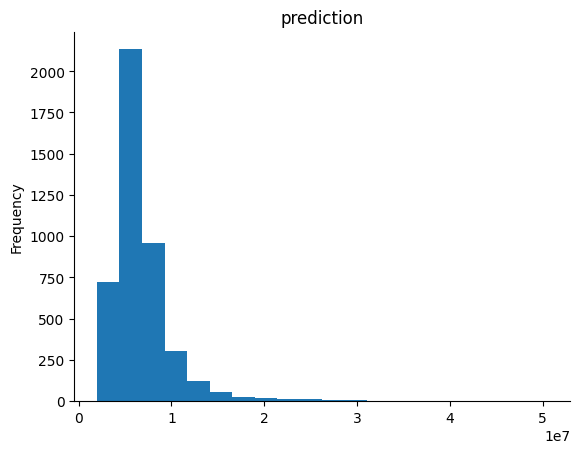

In [92]:
# @title prediction

from matplotlib import pyplot as plt
submission_df['prediction'].plot(kind='hist', bins=20, title='prediction')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Выкачиваю сабмишн в формате csv

In [93]:
submission_df.to_csv('submission_serdyukov.csv', index=False)

# Модель довольно устойчивая, на выходе получаю сабмишены  ~ 0.23 - 0.24 на kaggle